In [1]:
import numpy as np
import scipy
import pandas
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('notebook')
import h5py

In [2]:
import allel

#### filtering script
```
gatk-4.6.0.0/gatk VariantFiltration -R /scratch/project_2006658/birch_SNPchip/genome/Bpen_hifiasm_V5834.bp.p_ctg.hic.corrected.chr8added.2.fa -V ../merged.vcf.gz -O merged_hard_filter1.vcf.gz --filter-name "QD5" --filter-expression "QD < 5.0" --filter-name "MQ55" --filter-expression "MQ < 55.0" --filter-name "SOR3" --filter-expression "SOR > 3.0" --filter-name "MQRankSumMinus12.5" --filter-expression "MQRankSum < -12.5" --filter-name "MQRankSumPlus12.5" --filter-expression "MQRankSum > 12.5"  --filter-name "ReadPosRankSumMinus8" --filter-expression "ReadPosRankSum < -8.0" --filter-name "ReadPosRankSumPlus8" --filter-expression "ReadPosRankSum > 8.0" --filter-name "DP20info" --filter-expression "DP < 20.0" --filter-name "FS60" --filter-expression "FS > 60.0" --genotype-filter-name "DP10" --genotype-filter-expression "DP < 10.0" --genotype-filter-name "GQ20" --genotype-filter-expression "GQ < 20.0"

/projappl/project_2006658/gatk-4.6.0.0/gatk SelectVariants --variant ./merged_hard_filter1.vcf.gz --exclude-filtered true --exclude-non-variants true --restrict-alleles-to BIALLELIC --set-filtered-gt-to-nocall true --output merged_hard_filter22.vcf.gz 

vcftools --gzvcf merged_hard_filter22.vcf.gz --max-missing 0.9 --recode --recode-INFO-all --remove-filtered-all --stdout |bgzip > merged_hard_filter3.vcf.gz

vcftools --gzvcf merged_hard_filter3.vcf.gz --maf 0.05 --recode --recode-INFO-all --remove-filtered-all --stdout |bgzip > merged_hard_filter4.vcf.gz

/scratch/project_2006658/gatk-4.3.0.0/gatk SelectVariants --variant merged_hard_filter4.vcf.gz --select-type-to-include SNP --exclude-filtered true --exclude-non-variants true --restrict-alleles-to BIALLELIC --set-filtered-gt-to-nocall true --output final_filtered.vcf.gz

```

| Sample                | Vars      | SNP  | Indel  | Ts/Tv |
|-----------------------|-----------|------|--------|-------|
| merged_hard_filter1   | 80633785 | 68795458 | 16711178 | 1.65  |
| merged_hard_filter22  | 32470476 | 28536884 | 3933592  | 2.05  |
| merged_hard_filter3   | 25087061 | 22120549 | 2966512  | 1.98  |
| merged_hard_filter4   | 5953110  | 5421934  | 531176   | 2.51  |
| final_filtered        | 5421934  | 5421934  | 0       | 2.51  |

In [3]:
callset_fn = './final_hardfiltered_snps.h5'
callset = h5py.File(callset_fn, mode='r')
callset

<HDF5 file "final_hardfiltered_snps.h5" (mode r)>

In [4]:
calldata = callset['calldata']

In [5]:
variants = callset['variants']
variants


<HDF5 group "/variants" (39 members)>

In [6]:
variants = allel.VariantChunkedTable(callset['variants'], 
                                     names=['POS', 'REF', 'ALT', 'DP', 'QUAL', 'AN', 'MQ', 'QD', 'SOR', 'MQRankSum', 'ReadPosRankSum', 'numalt'])
variants

<VariantChunkedTable shape=(5421934,) dtype=[('POS', '<i4'), ('REF', 'O'), ('ALT', 'O', (3,)), ('DP', '<i4'), ('QUAL', '<f4'), ('AN', '<i4'), ('MQ', '<f4'), ('QD', '<f4'), ('SOR', '<f4'), ('MQRankSum', '<f4'), ('ReadPosRankSum', '<f4'), ('numalt', '<i4')]
   nbytes=372.3M cbytes=126.4M cratio=2.9
   values=h5py._hl.group.Group>

In [7]:
genotypes = allel.GenotypeChunkedArray(calldata['GT'])
genotypes

<GenotypeChunkedArray shape=(5421934, 370, 2) dtype=int8 chunks=(65536, 64, 2)
   nbytes=3.7G cbytes=623.3M cratio=6.1
   compression=gzip compression_opts=1
   values=h5py._hl.dataset.Dataset>

In [8]:
ac = genotypes.count_alleles()
ac

<AlleleCountsChunkedArray shape=(5421934, 2) dtype=int32 chunks=(131072, 2)
   nbytes=41.4M cbytes=17.4M cratio=2.4
   compression=gzip compression_opts=1
   values=h5py._hl.dataset.Dataset>

In [9]:
biallelic = (ac.max_allele() == 1)
biallelic[:30]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [10]:
def plot_variant_hist(f, bins=30):
    x = variants[f][:]
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.despine(ax=ax, offset=10)
    ax.hist(x, bins=bins)
    ax.set_xlabel(f)
    ax.set_ylabel('No. variants')
    ax.set_title('Variant %s distribution' % f)

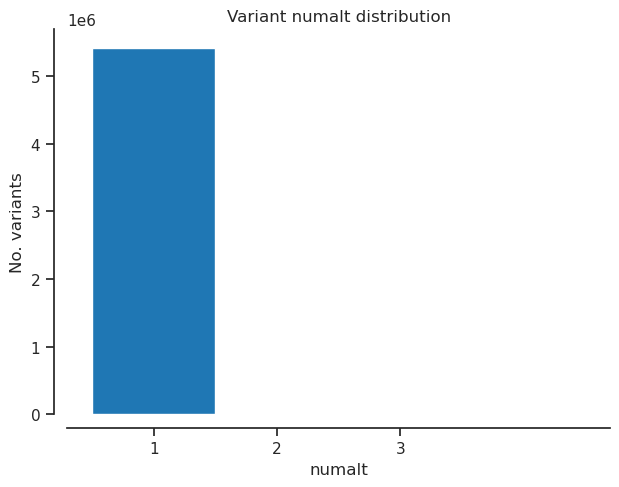

In [11]:
plot_variant_hist('numalt', bins=np.arange(0.5, 5.5, 1))
plt.gca().set_xticks([1,2,3])

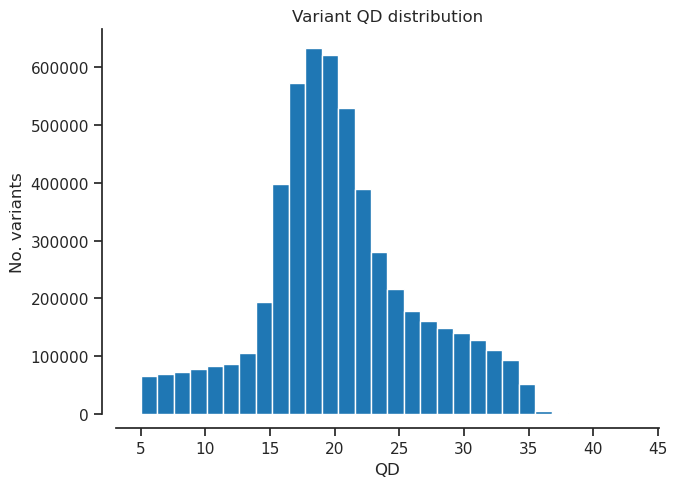

In [12]:
plot_variant_hist('QD')

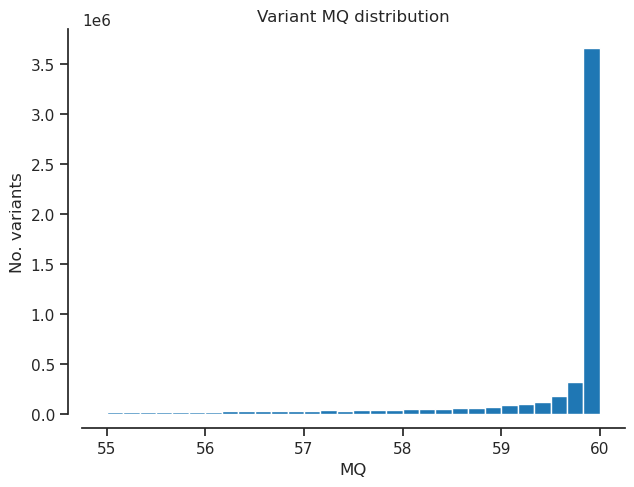

In [13]:
plot_variant_hist('MQ')

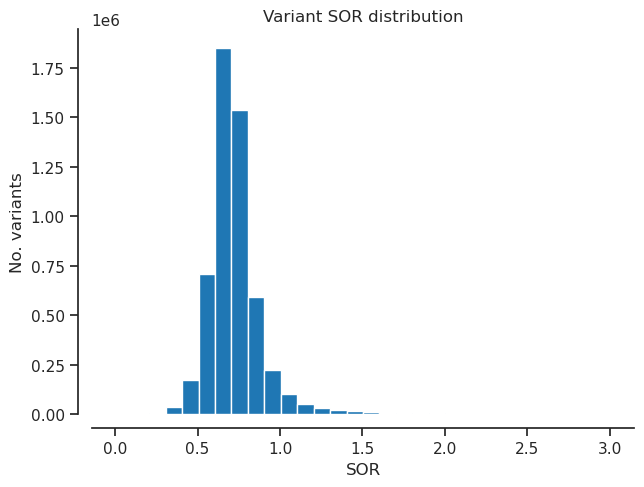

In [14]:
plot_variant_hist('SOR')

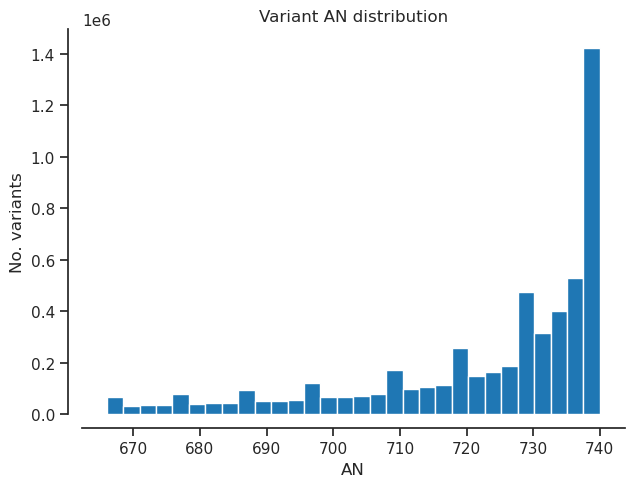

In [15]:
plot_variant_hist('AN')

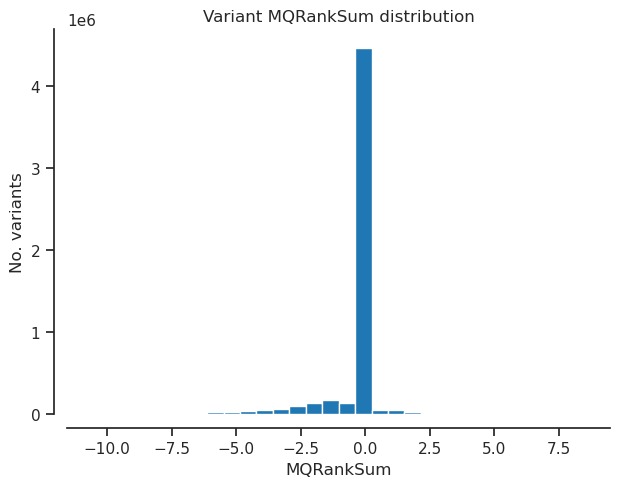

In [23]:
plot_variant_hist('MQRankSum')

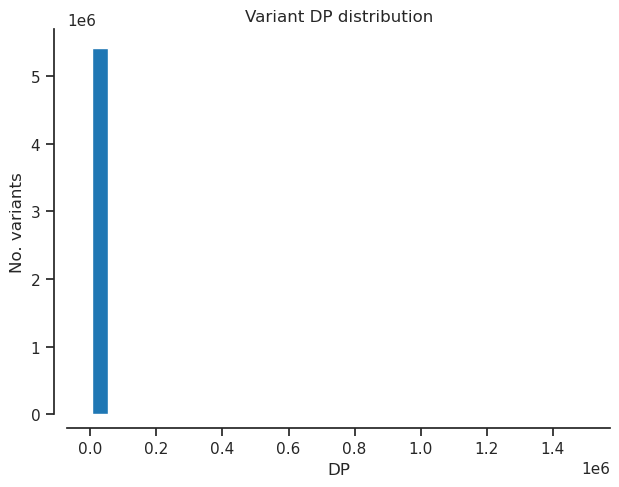

In [24]:
plot_variant_hist('DP')

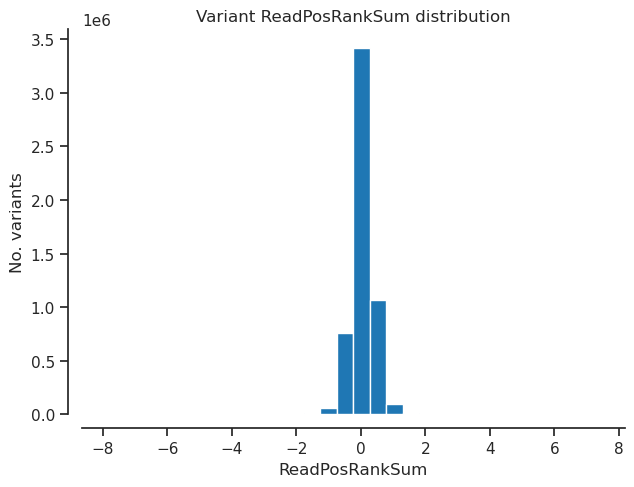

In [25]:
plot_variant_hist('ReadPosRankSum')

In [16]:
n_variants = len(genotypes)
n_variants

5421934

In [17]:
pc_missing = genotypes.count_missing(axis=0)[:] * 100 / n_variants
pc_het = genotypes.count_het(axis=0)[:] * 100 / n_variants

In [18]:
genotypes.count_het(axis=0)[0]

1547935

In [19]:
def plot_genotype_frequency(pc, title):
    fig, ax = plt.subplots(figsize=(24, 5))
    sns.despine(ax=ax, offset=24)
    left = np.arange(len(pc))
    palette = sns.color_palette("hls", 28)
    ax.bar(left, pc)
    ax.set_xlim(0, len(pc))
    ax.set_xlabel('Sample index')
    ax.set_ylabel('Percent calls')
    ax.set_title(title)

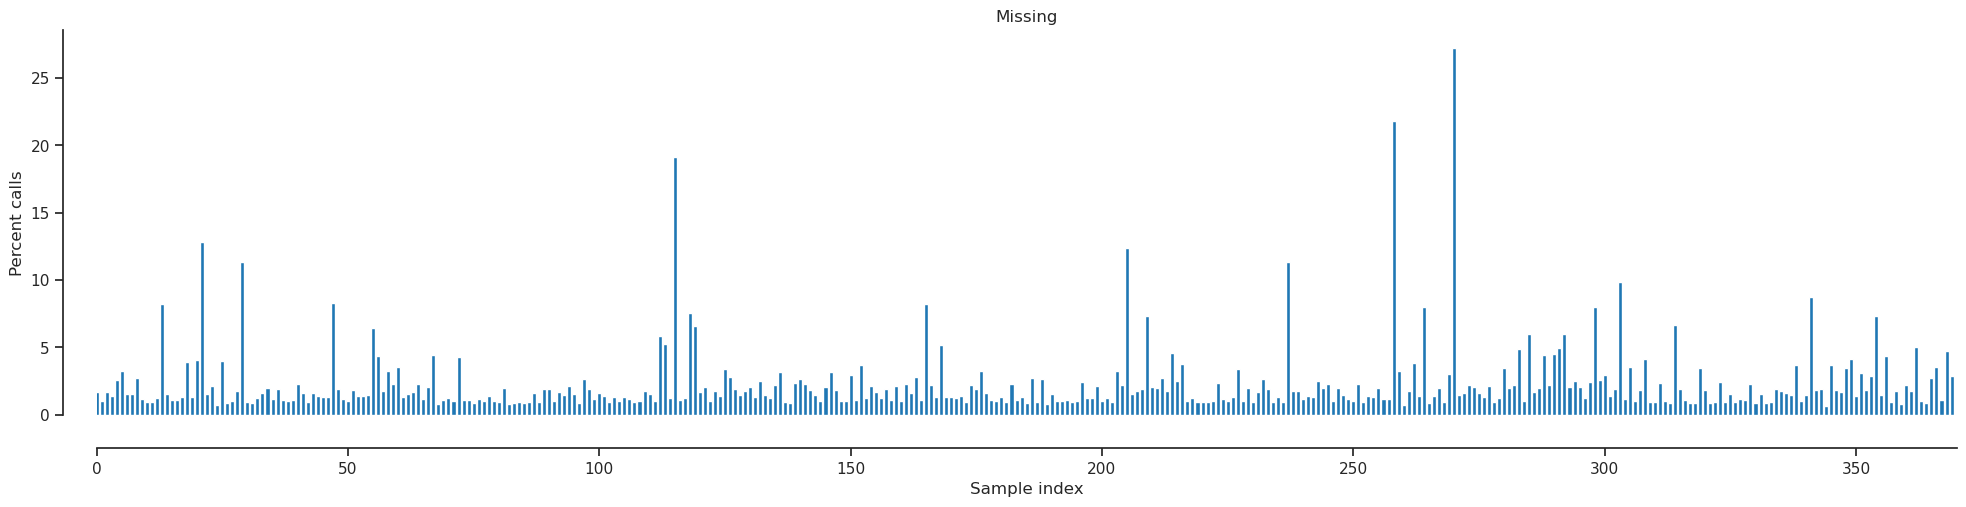

In [20]:
plot_genotype_frequency(pc_missing, 'Missing')


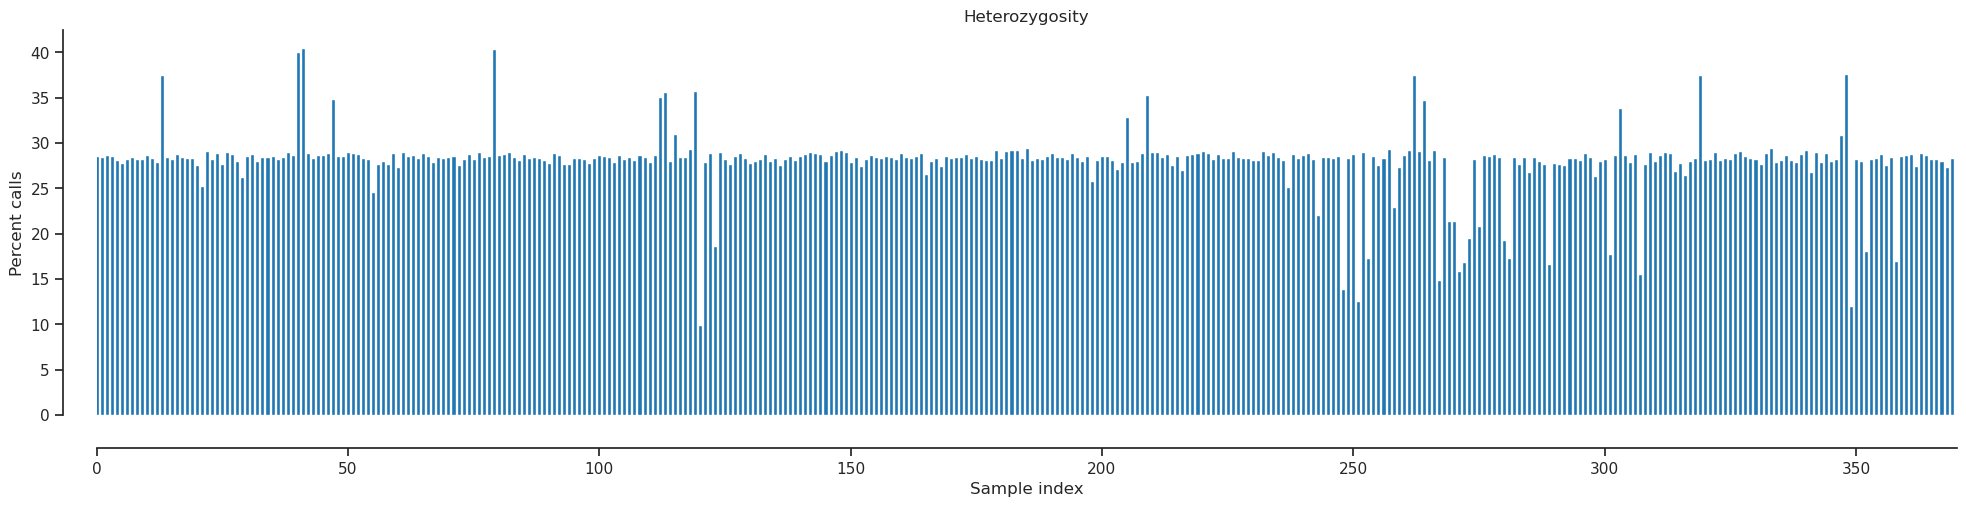

In [21]:
plot_genotype_frequency(pc_het, 'Heterozygosity')

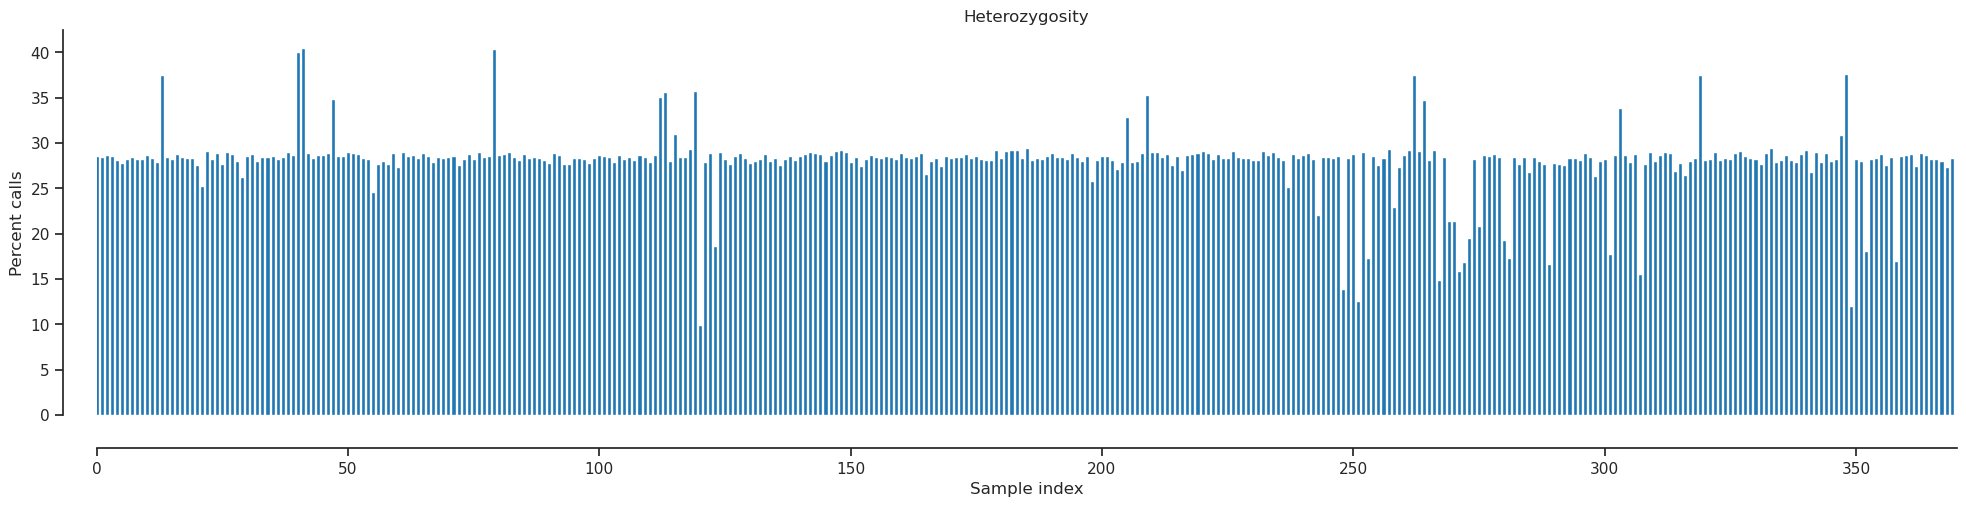

In [22]:
to_save = plot_genotype_frequency(pc_het, 'Heterozygosity')
plt.savefig('hetero_filtered_snps.png')

# vcftools --het

In [48]:
#vcftools --gzvcf final_filtered.vcf.gz --het --> output is out.het
vcftools_hetero = pandas.read_csv('../../out.het', sep='\t')

In [49]:
vcftools_hetero

,INDV,O(HOM),E(HOM),N_SITES,F
0,E10523,2344458,2362497.4,3181064,-0.02204
1,E1599,2364415,2372534.9,3193972,-0.00989
2,E1994,2341182,2361375.3,3179675,-0.02468
3,E2101,2353267,2367127.5,3187178,-0.01690
4,E2812,2341010,2349956.0,3164792,-0.01098
...,...,...,...,...,...
365,V5932,2329661,2345451.6,3159064,-0.01941
366,V594,2312097,2337070.3,3148226,-0.03079
367,V596,2396500,2371005.9,3192059,0.03105
368,V597,2312184,2320872.3,3126886,-0.01078


In [50]:
vcftools_hetero['heterozygosity_rate'] = 1- vcftools_hetero['O(HOM)'] / vcftools_hetero['N_SITES']

In [51]:
vcftools_hetero

,INDV,O(HOM),E(HOM),N_SITES,F,heterozygosity_rate
0,E10523,2344458,2362497.4,3181064,-0.02204,0.262996
1,E1599,2364415,2372534.9,3193972,-0.00989,0.259726
2,E1994,2341182,2361375.3,3179675,-0.02468,0.263704
3,E2101,2353267,2367127.5,3187178,-0.01690,0.261646
4,E2812,2341010,2349956.0,3164792,-0.01098,0.260296
...,...,...,...,...,...,...
365,V5932,2329661,2345451.6,3159064,-0.01941,0.262547
366,V594,2312097,2337070.3,3148226,-0.03079,0.265587
367,V596,2396500,2371005.9,3192059,0.03105,0.249231
368,V597,2312184,2320872.3,3126886,-0.01078,0.260547


([], [])

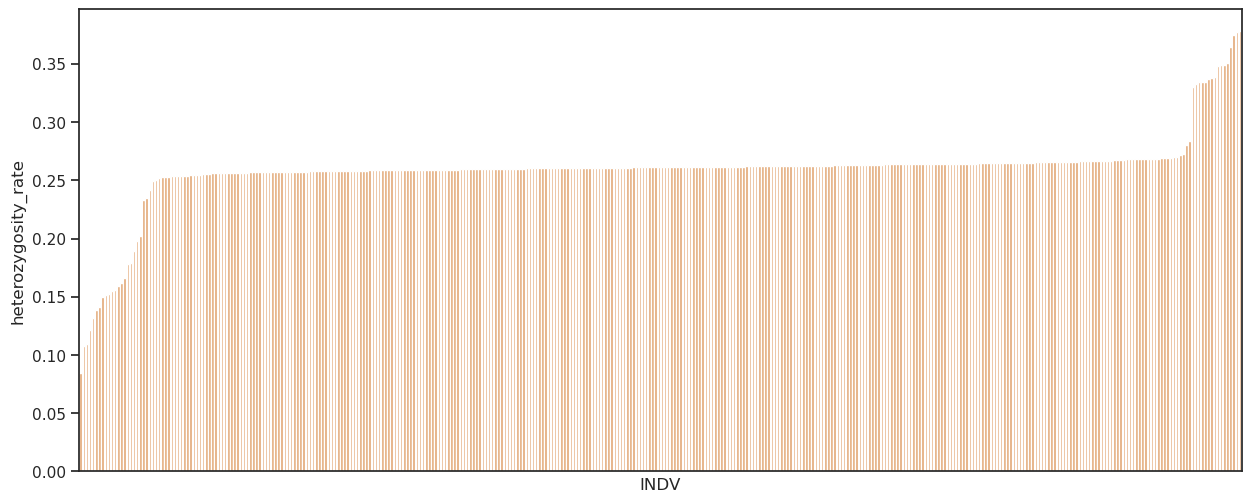

In [52]:
df_sorted = vcftools_hetero.sort_values(by='heterozygosity_rate')
plt.figure(figsize=(15, 6))
sns.barplot(x='INDV', y='heterozygosity_rate',
            data=df_sorted,
            color='sandybrown')
plt.xticks([])

In [38]:
genotypes.count_het(axis=0)[0]

1547935

In [39]:
genotypes.count_hom(axis=0)[0]

3782487

In [41]:
genotypes

<GenotypeChunkedArray shape=(5421934, 370, 2) dtype=int8 chunks=(65536, 64, 2)
   nbytes=3.7G cbytes=623.3M cratio=6.1
   compression=gzip compression_opts=1
   values=h5py._hl.dataset.Dataset>

In [45]:
genotypes.count_called(axis=0)[0]

5330422

In [46]:
genotypes.count_missing(axis=0)[0]

91512

In [47]:
pc_het[0]

28.549499127064255

In [53]:
vcftools_hetero.iloc[0]

INDV                      E10523
O(HOM)                   2344458
E(HOM)                 2362497.4
N_SITES                  3181064
F                       -0.02204
heterozygosity_rate     0.262996
Name: 0, dtype: object